In [1]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname((os.path.abspath(os.getcwd()))))

from datasets import ECGDataset
from models import threshold_net


/data/liudan/anaconda3/envs/omega/lib/python3.10/site-packages/pytorch_wavelets/dtcwt/coeffs.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


In [10]:
noise_type = "emb"
snr_db = -4

dataset = ECGDataset(
    split="test",
    noise_type=noise_type,
    snr_db=snr_db,
    split_dir="./data_split",
)

# idx = np.random.randint(0, len(dataset) - 1)
# print(idx)
# # idx = 860
# # idx = 513
# # idx = 1439
# # idx=1558
# # idx=6

# noisy, clean = dataset[idx]

# print(noisy.shape, clean.shape)

# mean, std = dataset.get_stats()
# ori_noisy = noisy * std + mean


# plt.style.use("seaborn-v0_8-whitegrid")
# plt.rcParams.update({
#     "font.family": "serif",
#     "font.serif": ["Times", "DejaVu Serif"],
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "legend.fontsize": 11,
#     "lines.linewidth": 1.5,
# })

# fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

# time = np.arange(len(clean)) / 360


# ax.plot(time, clean.numpy(), color="#1f77b4", label="Clean ECG", linewidth=1.8)
# ax.plot(time, ori_noisy.numpy(), color="#d62728", label="Noisy ECG", alpha=0.7)
# ax.set_ylabel("Amplitude (mV)")
# ax.set_title(f"Channel I (Noise Type: {noise_type.upper()}, SNR = {snr_db} dB)")
# ax.legend(loc="upper right", frameon=True)



# plt.tight_layout(pad=1.2)


# plt.savefig("ecg_noisy_vs_clean.png", dpi=600, bbox_inches="tight")
# plt.show()


1407
torch.Size([1024]) torch.Size([1024])


/tmp/ipykernel_1300184/1646549830.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))
/tmp/ipykernel_13001

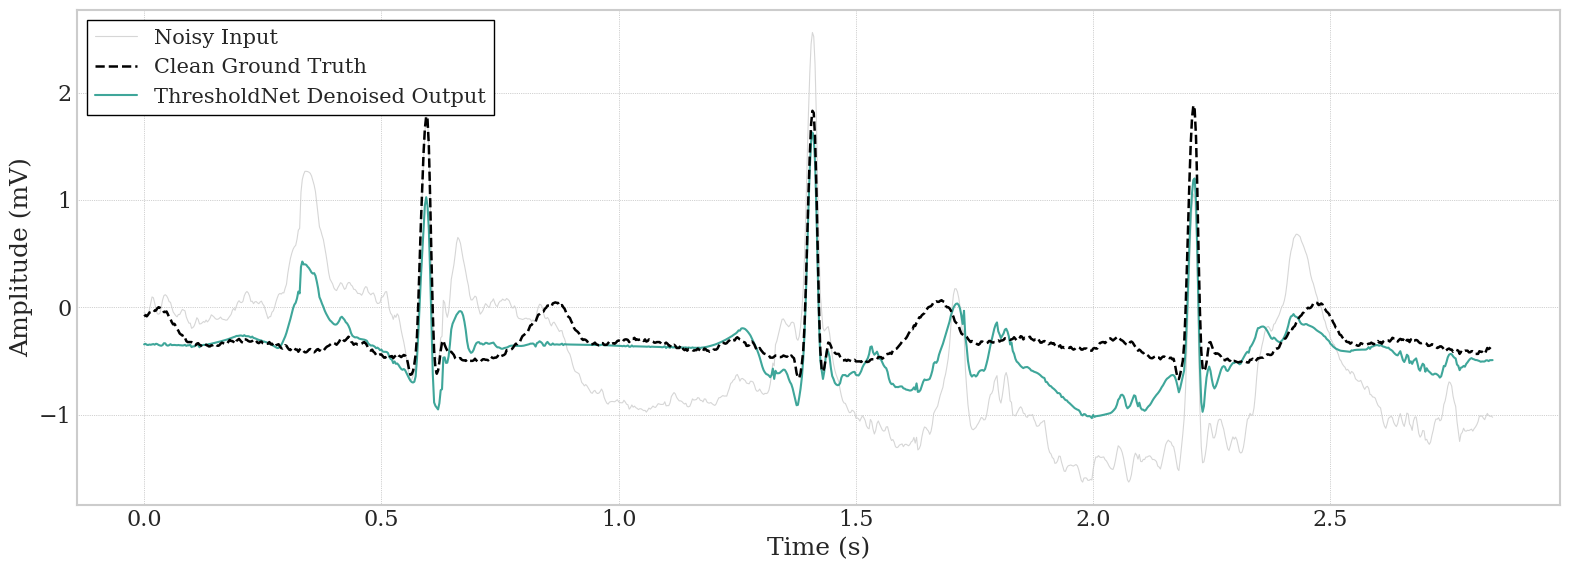

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch


import matplotlib.font_manager as font_manager

idx = np.random.randint(0, len(dataset) - 1)
print(idx)
# idx = 860
# idx = 513
# idx = 1439
# idx=1558
# idx=6

noisy, clean = dataset[idx]

print(noisy.shape, clean.shape)

mean, std = dataset.get_stats()
ori_noisy = noisy * std + mean


plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['axes.labelsize'] = 18      
plt.rcParams['xtick.labelsize'] = 16      
plt.rcParams['ytick.labelsize'] = 16      
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 1.5    
plt.rcParams['grid.alpha'] = 0.5          


denoised_output_dict = {}


device = torch.device("cpu") 

model = threshold_net.WaveletDenoisingNet(wave='db4', J=5, mode='symmetric')

ckpt_path = f"./checkpoints/best_WaveletDenoisingNet_emb_snr_-4.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device)
model.eval()

with torch.no_grad():

    noisy_input = torch.tensor(noisy, dtype=torch.float32).to(device)
    if noisy_input.ndim == 1:
        noisy_input = noisy_input.unsqueeze(0)
    
    denoised_output = model(noisy_input)


denoised_output = denoised_output.squeeze(0).cpu()
denoised_output = denoised_output * std + mean



t_clean = clean.cpu().numpy()
t_noisy = ori_noisy.cpu().numpy()


time = np.arange(len(t_clean)) / 360 


colors = {
    "Clean": "#000000",    
    "Noisy": "#cccccc",     
}

model_colors = [
    "#E63946", 
    "#457B9D", 
    "#2A9D8F", 
    "#E76F51", 
    "#8A2BE2", 
]


fig, ax = plt.subplots(1, 1, figsize=(16, 6), sharex=True, sharey=False)

ax.plot(time, t_noisy, label="Noisy Input", 
        color=colors["Noisy"], alpha=0.8, linewidth=0.8, zorder=1)


ax.plot(time, t_clean, label="Clean Ground Truth", 
        color=colors["Clean"], linewidth=1.8, linestyle='--', zorder=10)
    
ax.plot(time, denoised_output.numpy(), label="ThresholdNet Denoised Output", 
        color=model_colors[2], 
        alpha=0.9, linewidth=1.5, zorder=5)

ax.set_ylabel("Amplitude (mV)")
ax.set_xlabel("Time (s)") 
        
    
ax.grid(True, linestyle=':', linewidth=0.5, color='gray', alpha=0.7)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.minorticks_on()

ax.legend(loc='best', ncol=1, frameon=True, 
    edgecolor='black', framealpha=1.0, fancybox=False, fontsize=15)




plt.tight_layout(pad=1.5)



plt.savefig("ecg_denoising_comparison.png", dpi=600, bbox_inches="tight")

plt.show()